# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [32]:
# import libraries here; add more as necessary
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pprint
import random
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [33]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [34]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print("azdias shape: {} rows, {} columns".format(*azdias.shape))
azdias.head()

azdias shape: 891221 rows, 85 columns


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [35]:
print("feat_info shape: {} rows, {} columns".format(*feat_info.shape))
feat_info.head()

feat_info shape: 85 rows, 4 columns


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [36]:
# Step 1: Read in strings for missing values, parse out brackets and commas, and convert to list of strings

unknowns = pd.DataFrame(feat_info)
unknowns.missing_or_unknown = unknowns.missing_or_unknown.str.strip('[]').str.split(',')
unknowns.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [37]:
# Step 2: Create a function to identify missing value indicators that should be ints and do the appropriate conversion

def convert(values):
    """
    Takes a list of strings, attempts to convert values to integers, and returns modified list
    
    Parameters
    ----------
    values : list
        List of strings, some of which should be ints
        
    Returns
    -------
    list
        The original list with integers converted to numeric data type
    """
    
    new_values = []
    for value in values:
        try:
            value = int(value)
        except:
            value = str(value)
        finally:
            new_values.append(value)
            
    return new_values

In [38]:
# Step 3: Go through each feature and create a mapping dictionary from missing value indicators to np.nan
# (For features that do not have missing value indicators, print the feature name to do quality checking)

replace_dict = {}

for row in unknowns.itertuples():
    # If the feature does not contain any values to be mapped to nan, skip
    if row.missing_or_unknown == ['']:
        print(row.attribute)
        continue
    column = row.attribute
    nan_values = convert(row.missing_or_unknown)
    replace_dict[column] = {nan_value: np.nan for nan_value in nan_values}

GFK_URLAUBERTYP
GREEN_AVANTGARDE
ANZ_PERSONEN
ANZ_TITEL
ANZ_HH_TITEL
KONSUMNAEHE
GEBAEUDETYP_RASTER
MOBI_REGIO
ONLINE_AFFINITAET
KBA13_ANZAHL_PKW


In [39]:
# Step 4: Identify missing or unknown data values and convert them to NaNs with pandas 'replace' method
azdias_nan = azdias.replace(replace_dict)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [40]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Step 1: Print out the number of missing values for each feature
azdias_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

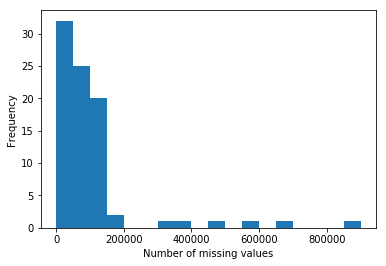

In [41]:
# Step 2: Plot histogram of frequencies of missing value counts to identify outliers

num_nans = []
for col in azdias_nan.columns:
    num_nans.append(azdias_nan[col].isnull().sum())

plt.hist(num_nans, bins=np.arange(0, 950000, 50000))
plt.xlabel('Number of missing values')
plt.ylabel('Frequency')
plt.show()

In [42]:
# Step 3: Remove the outlier columns from the dataset. 

outlier_threshold = 200000

outlier_cols = []
for col in azdias_nan.columns:
    if azdias_nan[col].isnull().sum() > outlier_threshold:
        outlier_cols.append(col)

print("Outlier features:")
for col in outlier_cols:
    print(col)
    
azdias_wout_outliers = azdias_nan.drop(labels=outlier_cols, axis=1)

Outlier features:
AGER_TYP
GEBURTSJAHR
TITEL_KZ
ALTER_HH
KK_KUNDENTYP
KBA05_BAUMAX


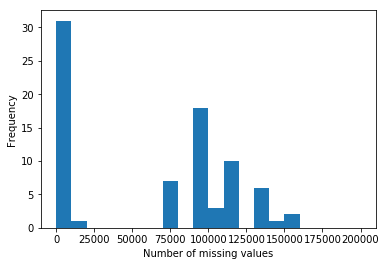

In [43]:
# Step 4: Re-plot the histogram with the outlier features removed

new_num_nans = []
for col in azdias_wout_outliers.columns:
    new_num_nans.append(azdias_nan[col].isnull().sum())

plt.hist(new_num_nans, bins=np.arange(0, 210000, 10000))
plt.xlabel('Number of missing values')
plt.ylabel('Frequency')
plt.show()

In [44]:
# Step 5: Print out groups of features that share the same number of missing values

nan_counter = collections.Counter(new_num_nans)
del nan_counter[0]

nan_dict = {}
for col in azdias_wout_outliers.columns:
    nan_dict[col] = azdias_wout_outliers[col].isnull().sum()
    
for nan_value in nan_counter.keys():
    print("Number of NaNs: {}".format(nan_value))
    print("--------------------------")
    for feature in nan_dict.keys():
        if nan_dict[feature] == nan_value:
            print(feature)
    print("\n")

Number of NaNs: 2881
--------------------------
ALTERSKATEGORIE_GROB


Number of NaNs: 4854
--------------------------
CJT_GESAMTTYP
GFK_URLAUBERTYP
LP_STATUS_FEIN
LP_STATUS_GROB
RETOURTYP_BK_S
ONLINE_AFFINITAET


Number of NaNs: 111196
--------------------------
HEALTH_TYP
SHOPPER_TYP
VERS_TYP


Number of NaNs: 97632
--------------------------
LP_LEBENSPHASE_FEIN


Number of NaNs: 94572
--------------------------
LP_LEBENSPHASE_GROB


Number of NaNs: 77792
--------------------------
LP_FAMILIE_FEIN
LP_FAMILIE_GROB


Number of NaNs: 108315
--------------------------
NATIONALITAET_KZ


Number of NaNs: 108164
--------------------------
PRAEGENDE_JUGENDJAHRE


Number of NaNs: 73499
--------------------------
SOHO_KZ
ANZ_PERSONEN
ANZ_TITEL
WOHNDAUER_2008


Number of NaNs: 18348
--------------------------
HH_EINKOMMEN_SCORE


Number of NaNs: 147988
--------------------------
W_KEIT_KIND_HH


Number of NaNs: 99611
--------------------------
ANZ_HAUSHALTE_AKTIV


Number of NaNs: 97008
-------

#### Discussion 1.1.2: Assess Missing Data in Each Column

Of the 85 features in the dataset, six of the features had 200,000 missing values or more, and they were removed from the dataset as outliers. The features are listed below:

* AGER_TYP (Best-ager typology)
* GEBURTSJAHR (Year of birth)
* TITEL_KZ (Academic title flag)
* ALTER_HH (Birthdate of head of household)
* KK_KUNDENTYP (Consumer pattern over past 12 months)
* KBA05_BAUMAX (Most common building type within the microcell)

For two of these features, I was not surprised to see a high proportion of missing values. 

I would expect a large number of outliers for "Best-ager typology", since this feature captures information only for elderly citizens, and only about 20% of the German population is over 65 years of age ([wikipedia](https://en.wikipedia.org/wiki/Demographics_of_Germany#Demographic_statistics)). Similarly, I would also expect only a small fraction of the population to have relevant data for the "Academic title flag". PhD's and Dr's do not constitute a large percentage of the population. 

I was initially surprised, however, to see the remaining four features missing many data.

Rough estimates of individuals' age were well-captured by features such as "Estimated age based on given name analysis", but "Year of birth" and "Birthdate of head of household" were relatively sparse. Thinking about my own experience of buying products online, I imagine that my exact age would be readily available. Probably 20% of my purchases ask me to enter my date of birth. Similarly, I assume that my "Consumer pattern over past 12 months" would also be easily attainable. My primary hypothesis, then, as to why these data are limited in the German dataset would be that European laws are more restrictive around the sharing of personal data from online sources. A secondary hypothesis could be that these data are available, but they are controlled by large technology companies such as Google, and this particular firm did not procure the data for this study. The last feature with many missing values - "Most common building type within the microcell" - may have been obtained from a focused study rather than a nation-wide census.

After removing these outlier features from the dataset, several clusters were identified with the same number of missing values.

In general, I would hypothesize that clusters of features with the same number of missing values likely originated from the same study. I thought several of these clusters revealed interesting information:

* **Person-level features:** One cluster of features was missing only 4854 values - most of them related to Person-level data. This cluster was notable due to the fact that so few values were missing. I would expect these data to be especially valuable for the analysis as they reveal nearly complete information about "Customer-Journey-Typology", "Vacation habits", "Social status", "Likelihood to return products", and "Online affinity".

* **Regional features:**  Several clusters emerged from features containing regional information. As an example, the PLZ8 region had several features with 116515 missing values. This means, however, that the remaining ~87% of the dataset DID contain data with PLZ8 features. The dataset also has specific information for the RR4 microcell, RR3 microcell, and RR1 region that are missing less than ~22% of values. I conclude that the dataset is biased toward consumers in these regions, which should be carefully noted when making conclusions based on the data.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

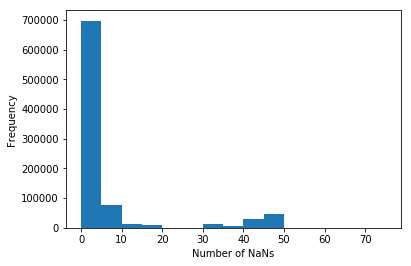

In [45]:
# How much data is missing in each row of the dataset?

row_nans = azdias_wout_outliers.isnull().sum(axis=1).tolist()
plt.hist(row_nans, bins=np.arange(0, 80, 5))
plt.xlabel('Number of NaNs')
plt.ylabel('Frequency')
plt.show()

In [46]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
num_nans = azdias_wout_outliers.isnull().sum(axis=1)
azdias_low_nans = azdias_wout_outliers[num_nans < 25]
azdias_high_nans = azdias_wout_outliers[num_nans >= 25]

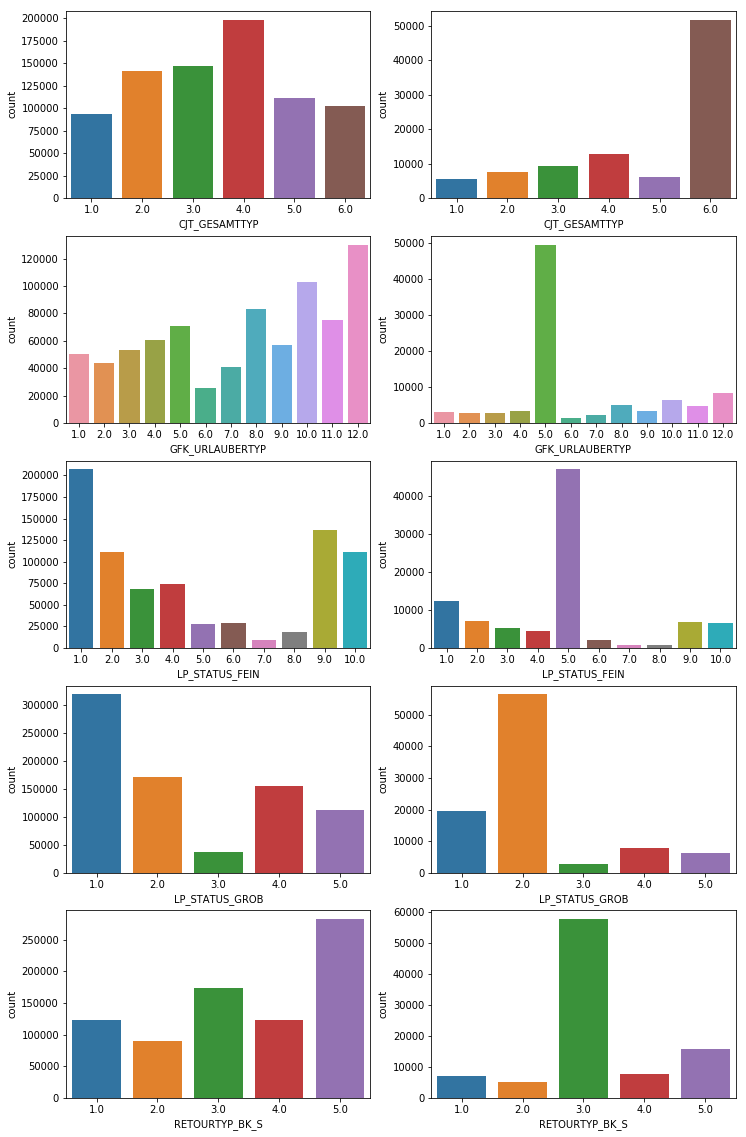

In [47]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
random.seed(42)
five_columns = [
    "CJT_GESAMTTYP",
    "GFK_URLAUBERTYP",
    "LP_STATUS_FEIN",
    "LP_STATUS_GROB",
    "RETOURTYP_BK_S",
]

fig = plt.figure(figsize=(12, 20))
ax = []
for i, col in enumerate(five_columns):
    plt.subplot(5, 2, 2*i+1)
    sns.countplot(azdias_low_nans[col])
    plt.subplot(5, 2, 2*i+2)
    sns.countplot(azdias_high_nans[col])


#### Discussion 1.1.3: Assess Missing Data in Each Row

The data with many missing values per row appear to be qualitatively different from the data with few or no missing values. Of the five features inspected, the data with many missing values were heavily biased toward one group. For instance, for the feature "GFK URLAUBERTYP" (Vacation habits) the rows with many missing values were predominantly "nature fans". Dropping these data, then, could potentially bias the analysis or lead to overlooking certain niche groups.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [48]:
# How many features are there of each data type?
feat_info.loc[feat_info['attribute'].isin(azdias_low_nans.columns)]['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [49]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cat_features = feat_info.loc[feat_info['attribute'].isin(azdias_low_nans.columns)]
cat_features = cat_features.loc[cat_features['type'] == 'categorical']
cat_features = cat_features.attribute.tolist()

cat_feat_info = []
for feature in cat_features:
    dtype = azdias_low_nans[feature].dtype
    unique_vals = azdias_low_nans[feature].unique()
    num_unique_vals = len(unique_vals)
    cat_feat_info.append((feature, dtype, num_unique_vals, unique_vals))
    
columns=['feature', 'data_type', 'num_unique_vals', 'unique_vals']
cat_feat_info = pd.DataFrame(cat_feat_info, columns=columns)
cat_feat_info.sort_values(by='num_unique_vals')

,feature,data_type,num_unique_vals,unique_vals
0,ANREDE_KZ,int64,2,"[2, 1]"
15,OST_WEST_KZ,object,2,"[W, O]"
4,GREEN_AVANTGARDE,int64,2,"[0, 1]"
11,SOHO_KZ,float64,2,"[1.0, 0.0]"
12,VERS_TYP,float64,3,"[2.0, 1.0, nan]"
9,NATIONALITAET_KZ,float64,4,"[1.0, 3.0, 2.0, nan]"
10,SHOPPER_TYP,float64,5,"[3.0, 2.0, 1.0, 0.0, nan]"
13,ZABEOTYP,int64,6,"[5, 3, 4, 1, 6, 2]"
8,LP_STATUS_GROB,float64,6,"[1.0, 2.0, 4.0, 5.0, 3.0, nan]"
6,LP_FAMILIE_GROB,float64,6,"[3.0, 1.0, nan, 5.0, 2.0, 4.0]"


In [50]:
# Re-encode categorical and mixed variable(s) to be kept in the analysis.
cat_feat_to_reencode = [
    'CJT_GESAMTTYP',
    'FINANZTYP',
    'GFK_URLAUBERTYP',
    'LP_FAMILIE_FEIN',
    'LP_FAMILIE_GROB',
    'LP_STATUS_FEIN',
    'LP_STATUS_GROB',
    'NATIONALITAET_KZ',
    'SHOPPER_TYP',
    'VERS_TYP',
    'ZABEOTYP',
    'GEBAEUDETYP',
    'OST_WEST_KZ',
    'CAMEO_DEUG_2015',
    'CAMEO_DEU_2015',
]

reencoded = pd.get_dummies(data=azdias_low_nans, columns=cat_feat_to_reencode)

#### Discussion 1.2.1: Re-Encode Categorical Features

Eighteen categorical variables were identified. The binary categorical variables with numeric representations were left as is. Categorical variables with non-numeric encoding or with more than two categories were one-hot encoded with pandas' get_dummies method.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [51]:
# Assess mixed variables

mixed_features = feat_info.loc[feat_info['attribute'].isin(azdias_low_nans.columns)]
mixed_features = mixed_features.loc[mixed_features['type'] == 'mixed']
mixed_features = mixed_features.attribute.tolist()

mixed_feat_info = []
for feature in mixed_features:
    dtype = azdias_low_nans[feature].dtype
    unique_vals = azdias_low_nans[feature].unique()
    num_unique_vals = len(unique_vals)
    mixed_feat_info.append((feature, dtype, num_unique_vals, unique_vals))
    
columns=['feature', 'data_type', 'num_unique_vals', 'unique_vals']
mixed_feat_info = pd.DataFrame(mixed_feat_info, columns=columns)
mixed_feat_info.sort_values(by='num_unique_vals')

,feature,data_type,num_unique_vals,unique_vals
5,PLZ8_BAUMAX,float64,6,"[1.0, 2.0, nan, 4.0, 5.0, 3.0]"
3,WOHNLAGE,float64,8,"[4.0, 2.0, 7.0, 3.0, 5.0, 1.0, 8.0, 0.0]"
1,LP_LEBENSPHASE_GROB,float64,13,"[6.0, 1.0, nan, 10.0, 2.0, 3.0, 5.0, 7.0, 12.0..."
2,PRAEGENDE_JUGENDJAHRE,float64,16,"[14.0, 15.0, 8.0, 3.0, 10.0, 11.0, 5.0, 9.0, 6..."
4,CAMEO_INTL_2015,object,22,"[51, 24, 12, 43, 54, 22, 14, 13, 15, 33, 41, 3..."
0,LP_LEBENSPHASE_FEIN,float64,41,"[21.0, 3.0, nan, 32.0, 8.0, 2.0, 5.0, 10.0, 4...."


In [52]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

decade_mapper = {
    1: 40,
    2: 40,
    3: 50,
    4: 50,
    5: 60,
    6: 60,
    7: 60,
    8: 70,
    9: 70,
    10: 80,
    11: 80,
    12: 80,
    13: 80,
    14: 90,
    15: 90,
}

movement_mapper = {
    1: 0,
    2: 1,
    3: 0,
    4: 1,
    5: 0,
    6: 1,
    7: 1,
    8: 0,
    9: 1,
    10: 0,
    11: 1,
    12: 0,
    13: 1,
    14: 0,
    15: 1,
}

reencoded['JUGENDJAHRE'] = reencoded['PRAEGENDE_JUGENDJAHRE'].map(decade_mapper)
reencoded['BEWEGUNG'] = reencoded['PRAEGENDE_JUGENDJAHRE'].map(movement_mapper)
reencoded = reencoded.drop(labels='PRAEGENDE_JUGENDJAHRE', axis=1)

In [53]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

reencoded['CAMEO_INTL_2015'] = reencoded['CAMEO_INTL_2015'].astype(np.float64)
reencoded['REICHTUM'] = reencoded['CAMEO_INTL_2015'] // 10
reencoded['LEBENSABSCHNITT'] = reencoded['CAMEO_INTL_2015'] % 10
reencoded = reencoded.drop(labels='CAMEO_INTL_2015', axis=1)

In [54]:
mix_feat_to_reencode = [
    'PLZ8_BAUMAX',
    'WOHNLAGE',
    'LP_LEBENSPHASE_GROB',
    'LP_LEBENSPHASE_FEIN',
]

reencoded = pd.get_dummies(data=reencoded, columns=mix_feat_to_reencode)

#### Discussion 1.2.2: Engineer Mixed-Type Features

PRAEGENDE_JUGENDJAHRE was split into two new features: (i) "JUGENDJAHRE", which captured the generation by decade, and (ii) "BEWEGUNG", which recorded the movement (mainstream vs. avantgarde). The original feature was dropped. CAMEO_INTL_2015 was split into two new variables: "REICHTUM" and "LEBENSABSCHNITT" - the first encoding "wealth" and the latter "life stage". Again, the original feature was dropped. The remaining four 'mixed' variables were one-hot encoded.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [55]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

reencoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797906 entries, 1 to 891220
Columns: 259 entries, ALTERSKATEGORIE_GROB to LP_LEBENSPHASE_FEIN_40.0
dtypes: float64(40), int64(22), uint8(197)
memory usage: 553.4 MB


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [56]:
def clean_data(df, replace_dict=replace_dict):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    Parameters
    ----------
    df : pandas DataFrame
        The data to be cleaned
    replace_dict : dict
        A dictionary of the form {feature: {null_value: numpy.nan, ...}, ...},
        which provides a mapping for null values to numpy.nan so that all nans
        can be properly converted with pandas 'replace' method
        
    Returns
    -------
    pandas DataFrame
        Cleaned data
    """
    
    
    # Step 1: Substitute NaN place-holders with numpy.nan
    # ---------------------------------------------------
    df = df.replace(replace_dict)
    
    
    # Step 2: Remove columns with high percentage of NaNs
    # ---------------------------------------------------
    outlier_columns = [
        'AGER_TYP',
        'GEBURTSJAHR',
        'TITEL_KZ',
        'ALTER_HH',
        'KK_KUNDENTYP',
        'KBA05_BAUMAX',
    ]
    df = df.drop(labels=outlier_columns, axis=1)
    
    
    # Step 3: Remove rows with 25 or more missing features
    # ----------------------------------------------------
    num_nans = df.isnull().sum(axis=1)
    df = df[num_nans < 25]

    
    # Step 4: One-hot encode non-binary or non-numeric categorical features
    # ---------------------------------------------------------------------
    cat_feat_to_reencode = [
        'CJT_GESAMTTYP',
        'FINANZTYP',
        'GFK_URLAUBERTYP',
        'LP_FAMILIE_FEIN',
        'LP_FAMILIE_GROB',
        'LP_STATUS_FEIN',
        'LP_STATUS_GROB',
        'NATIONALITAET_KZ',
        'SHOPPER_TYP',
        'VERS_TYP',
        'ZABEOTYP',
        'GEBAEUDETYP',
        'OST_WEST_KZ',
        'CAMEO_DEUG_2015',
        'CAMEO_DEU_2015',
    ]
    df = pd.get_dummies(data=df, columns=cat_feat_to_reencode)
    
    
    # Step 5: Re-engineer 'PRAEGENDE_JUGENDJAHRE' 
    # -------------------------------------------
    decade_mapper = {
        1: 40,
        2: 40,
        3: 50,
        4: 50,
        5: 60,
        6: 60,
        7: 60,
        8: 70,
        9: 70,
        10: 80,
        11: 80,
        12: 80,
        13: 80,
        14: 90,
        15: 90,
    }
    movement_mapper = {
        1: 0,
        2: 1,
        3: 0,
        4: 1,
        5: 0,
        6: 1,
        7: 1,
        8: 0,
        9: 1,
        10: 0,
        11: 1,
        12: 0,
        13: 1,
        14: 0,
        15: 1,
    }
    df['JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_mapper)
    df['BEWEGUNG'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_mapper)
    df = df.drop(labels='PRAEGENDE_JUGENDJAHRE', axis=1)
    
    
    # Step 6: Re-engineer "CAMEO_INTL_2015"
    # -------------------------------------
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(np.float64)
    df['REICHTUM'] = df['CAMEO_INTL_2015'] // 10
    df['LEBENSABSCHNITT'] = df['CAMEO_INTL_2015'] % 10
    df = df.drop(labels='CAMEO_INTL_2015', axis=1)

    
    # Step 7: One-hot encode remaining 'mixed' variables
    mix_feat_to_reencode = [
        'PLZ8_BAUMAX',
        'WOHNLAGE',
        'LP_LEBENSPHASE_GROB',
        'LP_LEBENSPHASE_FEIN',
    ]
    df = pd.get_dummies(data=df, columns=mix_feat_to_reencode)
    

    # Return the cleaned dataframe
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [57]:
fraction_nans = reencoded.isnull().any(axis=1).sum() / len(reencoded)
print("Fraction of rows with missing data: {:.2f}".format(fraction_nans))

Fraction of rows with missing data: 0.22


In [58]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imputer = Imputer(strategy='median')
imputed = imputer.fit_transform(reencoded)

In [59]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
scaled_data = scaler.fit_transform(imputed)

### Discussion 2.1: Apply Feature Scaling

Even though columns and rows with a high proportion of NaNs were removed in previous steps, 22% of the remaining rows still had one missing value or more. Simply dropping 22% of the data seemed to be capable of significantly altering the outcome of the analysis. Consequently, the missing data were replaced with the median value of the corresponding feature. The median was chosen because many of the columns were one-hot encoded categorical data, *i.e.*, zeros and ones. Choosing the mean would result in fractional data, which would be irrelevant. For continuous data, the median reduced the influence of outliers. The data were subsequently scaled to have a mean of zero and standard deviation of one.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [29]:
# Apply PCA to the data.

pca1 = PCA()
exploratory_pca = pca1.fit(scaled_data)

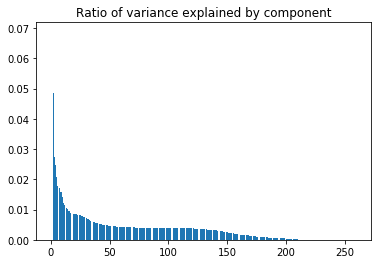

In [30]:
# Investigate the variance accounted for by each principal component.

y = exploratory_pca.explained_variance_ratio_
x = np.arange(1, len(y)+1)
plt.bar(x, y)
plt.title("Ratio of variance explained by component")
plt.show()

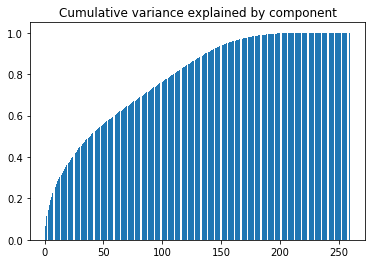

In [31]:
y = pd.Series(exploratory_pca.explained_variance_ratio_).cumsum()
x = np.arange(1, len(y)+1)
plt.bar(x, y)
plt.title("Cumulative variance explained by component")
plt.show()

In [60]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca2 = PCA(n_components=30)
pca2 = pca2.fit(scaled_data)
dim_reduced_data = pca2.transform(scaled_data)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

Thirty principal components were chosen for the remaining analysis. The initial principle component analysis on the dataset showed that the the first thirty or so components could explain at least ~1% of the variance each. After the first thirty components, the amount of variance explained per component dropped down to ~0.5%, plateaued, and then eventually dropped to ~0% after 150 components. The cumulative graph of variance explained by component showed that the first thirty components could explain ~40% of the variance in the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [33]:
def graph_component(pca, features, index):
    """Plot the weights for each feature for a given principle component and
       print list of features with weights relative to the given principle 
       component
    
    Parameters
    ----------
    pca : sklearn.decomposition.PCA
        A fitted principle component decomposition
    features : list-like of strings
        The features names from the dataset before decomposition
    index : int
        Index of the component to analyze
    """
    
    w = list(range(len(features)))
    x = features
    y = pca.components_[index]
    sorted_components = sorted(zip(x, y), key=lambda x: x[1])
    x, y = zip(*sorted_components)
    
    plt.figure(figsize=(18,6))
    plt.bar(w, y, tick_label=x)
    plt.title("Feature Weights for Principle Component with Index {}".format(index))
    plt.xticks([], [])
    plt.xlabel('Feature')
    plt.ylabel('Weight')
    plt.show()
    
    print("{:<30}{:<10}".format('Feature', 'Weight'))
    print("--------------------          ----------")
    for i, j in sorted_components:
        print("{:<30}{:<10.3f}".format(i, j))

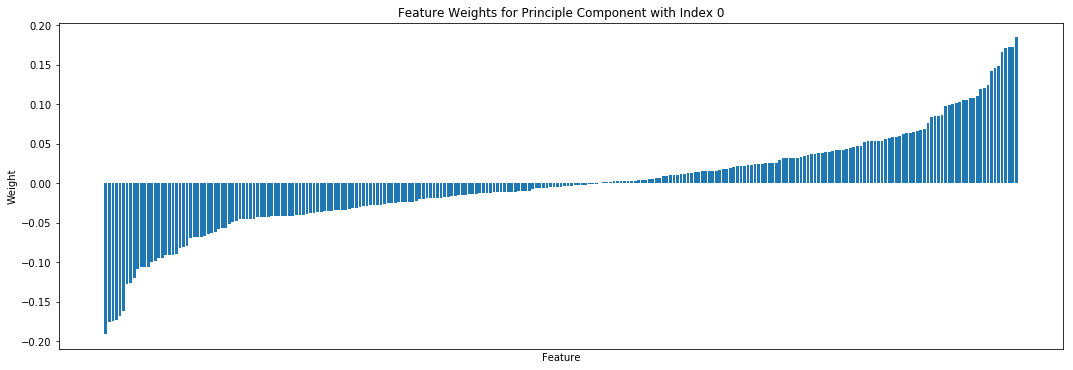

Feature                       Weight    
--------------------          ----------
MOBI_REGIO                    -0.191    
KBA05_ANTG1                   -0.176    
FINANZ_MINIMALIST             -0.174    
PLZ8_ANTG1                    -0.173    
KBA05_GBZ                     -0.169    
PLZ8_BAUMAX_1.0               -0.162    
KONSUMNAEHE                   -0.128    
PLZ8_GBZ                      -0.127    
INNENSTADT                    -0.120    
LP_STATUS_GROB_4.0            -0.109    
LP_STATUS_FEIN_9.0            -0.106    
LP_STATUS_FEIN_10.0           -0.106    
LP_STATUS_GROB_5.0            -0.106    
LEBENSABSCHNITT               -0.100    
WOHNLAGE_7.0                  -0.099    
GREEN_AVANTGARDE              -0.095    
BEWEGUNG                      -0.095    
BALLRAUM                      -0.091    
ZABEOTYP_1                    -0.091    
GEBAEUDETYP_RASTER            -0.090    
LP_LEBENSPHASE_GROB_12.0      -0.089    
GEBAEUDETYP_1.0               -0.082    
CAMEO_DEUG_2015_

ORTSGR_KLS9                   0.148     
PLZ8_ANTG4                    0.166     
REICHTUM                      0.171     
PLZ8_ANTG3                    0.172     
HH_EINKOMMEN_SCORE            0.172     
LP_STATUS_GROB_1.0            0.184     


In [34]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

graph_component(pca=pca2, features=reencoded.columns, index=0)

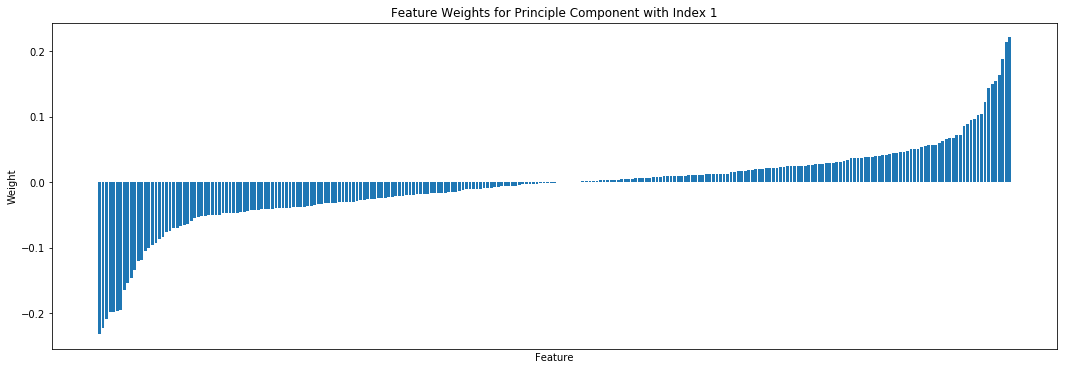

Feature                       Weight    
--------------------          ----------
JUGENDJAHRE                   -0.231    
FINANZ_SPARER                 -0.222    
FINANZ_UNAUFFAELLIGER         -0.208    
SEMIO_REL                     -0.198    
FINANZ_ANLEGER                -0.197    
SEMIO_TRADV                   -0.196    
SEMIO_PFLICHT                 -0.194    
SEMIO_RAT                     -0.164    
ONLINE_AFFINITAET             -0.153    
SEMIO_KULT                    -0.146    
FINANZTYP_1                   -0.134    
SEMIO_MAT                     -0.120    
SEMIO_FAM                     -0.119    
ZABEOTYP_4                    -0.104    
LP_LEBENSPHASE_GROB_1.0       -0.100    
LP_STATUS_FEIN_2.0            -0.096    
ZABEOTYP_5                    -0.092    
LP_LEBENSPHASE_GROB_9.0       -0.086    
FINANZTYP_4                   -0.083    
LP_STATUS_FEIN_5.0            -0.076    
LP_LEBENSPHASE_FEIN_1.0       -0.074    
GFK_URLAUBERTYP_9.0           -0.069    
LP_FAMILIE_GROB_

In [35]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

graph_component(pca=pca2, features=reencoded.columns, index=1)

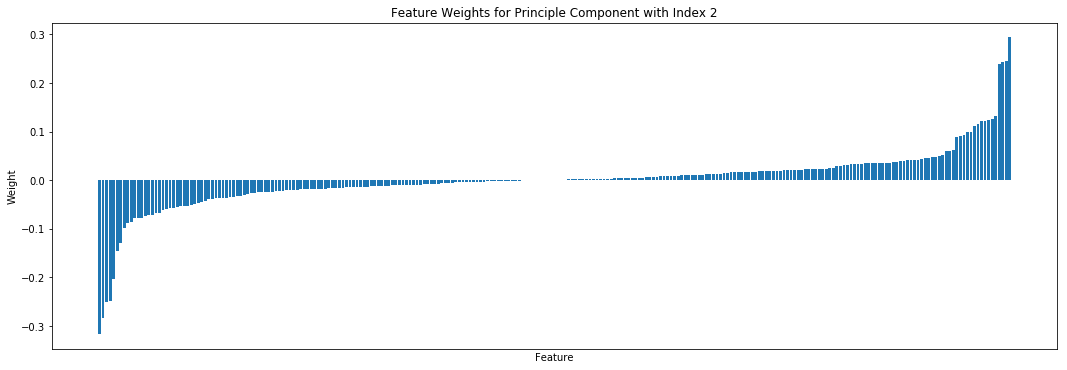

Feature                       Weight    
--------------------          ----------
ANREDE_KZ                     -0.316    
SEMIO_KAEM                    -0.282    
SEMIO_KRIT                    -0.250    
SEMIO_DOM                     -0.248    
SEMIO_ERL                     -0.203    
FINANZ_ANLEGER                -0.145    
SEMIO_RAT                     -0.128    
LP_STATUS_FEIN_4.0            -0.099    
FINANZTYP_1                   -0.088    
SHOPPER_TYP_2.0               -0.086    
INNENSTADT                    -0.078    
LP_FAMILIE_GROB_3.0           -0.078    
LP_LEBENSPHASE_GROB_6.0       -0.078    
FINANZ_HAUSBAUER              -0.073    
BALLRAUM                      -0.072    
WOHNLAGE_7.0                  -0.071    
LP_STATUS_FEIN_2.0            -0.068    
HH_EINKOMMEN_SCORE            -0.067    
KONSUMNAEHE                   -0.061    
ZABEOTYP_4                    -0.060    
PLZ8_BAUMAX_1.0               -0.057    
KKK                           -0.057    
ZABEOTYP_3      

In [36]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

graph_component(pca=pca2, features=reencoded.columns, index=2)

### Discussion 2.3: Interpret Principal Components

**Principal component #1**  

The first principal component appears to capture the dichotomy between low-income earners that rent (and also tend to move often between homes) and high-income earners that own their own home. 


High positive weights: 

|Feature|Description|Notes|
|:------|:----------|:----|
|MOBI_REIGO|Movement patterns|1 = very high|
|KBA05_ANTG1|Number of 1-2 family houses in the microcell| |
|FINANZ_MINIMALIST|Financial minimalist|1 = very high|
|PLZ8_ANTG1|Number of 1-2 family houses in the PLZ8 region| |
|KBA05_GBZ|Number of buildings in the microcell| |
|PLZ8_BAUMAX_1.0|1-2 family homes most common| |

High negative weights: 

|Feature|Description|Notes|
|:------|:----------|:----|
|PLZ8_ANTG4|Number of 10+ family houses in the PLZ8 region| |
|REICHTUM|Wealth|1 = wealthy|
|PLZ8_ANTG3|Number of 6-10 family houses in the PLZ8 region| |
|HH_EINKOMMEN_SCORE|Estimated household net income|1 = highest income|
|LP_STATUS_GROB_1.0|Social status, rough scale: Low-income earners| |


**Principal component #2**  

The second principal component seems to contrast techologically-savvy young people that shop somewhat emotionally (*e.g.*, based on sensuality, an outside influence such as an event, or a personal value such as sustainability) versus older, traditional individuals who tend to save or invest money methodically.

High positive weights:

|Feature|Description|Notes|
|:------|:----------|:----|
|JUGENDJAHRE|Formative decade| |
|FINANZ_SPARER|Financial saver|1 = very high|
|FINANZ_UNAUFFAELLIGER|Financially inconspicuous|1 = very high|
|SEMIO_REL|Religious personality|1 = highest affinity|
|FINANZ_ANLEGER|Financial investor|1 = very high|
|SEMIO_PFLICHT|Dutiful personality|1 = highest affinity|
|SEMIO_RAT|Rational personality|1 = highest affinity
|ONLINE_AFFINITAET|Online affinity|1 = low|

High negative weights:

|Feature|Description|Notes|
|:------|:----------|:----|
|RETOURTYP_BK_S|Return type|1 = High return rate|
|SEMIO_LUST|Sensual personality|1 = highest affinity|
|SEMIO_ERL|Event-oriented personality|1 = highest affinity|
|ZABEOTYP_3|Fair-supplied energy consumption| |
|FINANZ_VORSORGER|Financially prepared|1 = very high|
|ALTERSKATEGORIE_GROB|Rough age category|1 = <30 years|


**Principal component #3**  

This component contrasts individuals that identify as male or that display traits traditionally categorized as masculine, *e.g.*, rationality and assertiveness, with those that identify as female or display more whimsical, relationship-oriented affinities.

High positive weights:

|Feature|Description|Notes|
|:------|:----------|:----|
|ANREDE_KZ|Gender|1 = male, 2 = female|
|SEMIO_KAEM|Combative personality|1 = highest affinity|
|SEMIO_KRIT|Critical minded|1 = highest affinity|
|SEMIO_DOM|Dominant personality|1 = highest affinity|
|SEMIO_ERL|Event-oriented|1 = highest affinity|
|FINANZ_ANLEGER|Investor|1 = very high|

High negative weights:

|Feature|Description|Notes|
|:------|:----------|:----|
|SEMIO_KULT|Cultural-minded|1 = highest affinity|
|SEMIO_SOZ|Socially-minded|1 = highest affinity|
|SEMIO_FAM|Family-minded|1 = highest affinity|
|SEMIO_VERT|Dreamful|1 = highest affinity|

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [43]:
def score_ave_dist_center(n_clusters, data):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    distances = model.fit_transform(data)
    ave_distance = distances.min(axis=1).mean()
    
    return ave_distance

In [44]:
list_n_clusters = []
list_ave_distances = []

for n_clusters in range(2, 21):
    print("Working on model with {} clusters...".format(n_clusters))
    ave_distance = score_ave_dist_center(n_clusters=n_clusters, data=dim_reduced_data)
    list_n_clusters.append(n_clusters)
    list_ave_distances.append(ave_distance)

Working on model with 2 clusters...
Working on model with 3 clusters...
Working on model with 4 clusters...
Working on model with 5 clusters...
Working on model with 6 clusters...
Working on model with 7 clusters...
Working on model with 8 clusters...
Working on model with 9 clusters...
Working on model with 10 clusters...
Working on model with 11 clusters...
Working on model with 12 clusters...
Working on model with 13 clusters...
Working on model with 14 clusters...
Working on model with 15 clusters...
Working on model with 16 clusters...
Working on model with 17 clusters...
Working on model with 18 clusters...
Working on model with 19 clusters...
Working on model with 20 clusters...


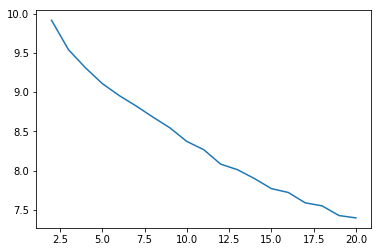

In [45]:
plt.plot(list_n_clusters, list_ave_distances)
plt.show()

In [61]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

model_8_clusters = KMeans(n_clusters=8, random_state=42)
model_8_clusters.fit(dim_reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [146]:
gen_pop_8_cluster_preds = model_8_clusters.labels_

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

The data were clustered using a K-Means algorithm with the number of clusters ranging from two to twenty. After examining the resulting Scree plot, no clear "elbow" was evident when increasing the number of clusters. Perhaps the distance metric dropped more dramatically for the first 4-5 features, but only marginally so. I chose to complete the remainder of the analysis with 8 clusters, since this would give the algorithm the opportunity to divide the population into binary combinations of the first three principal components (2^3 = 8), if possible.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [63]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [64]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_cleaned = clean_data(customers)

# After applying one-hot encoding, some columns from the general population 
# data were missing in the customer data. The columns were added in with all
# zero values
missing_cols = set(reencoded.columns) - set(customers_cleaned.columns)
for col in missing_cols:
    customers_cleaned[col] = 0.0

customers_imputed = imputer.fit_transform(customers_cleaned)
customers_scaled = scaler.fit_transform(customers_imputed)
customers_dim_reduced = pca2.transform(customers_scaled)
customers_4_clusters = model_4_clusters.predict(customers_dim_reduced)
customers_8_clusters = model_8_clusters.predict(customers_dim_reduced)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [76]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

gen_pop_counter = collections.Counter(model_8_clusters.labels_)
customer_counter = collections.Counter(customers_8_clusters)
gen_pop_x, gen_pop_y = zip(*sorted(gen_pop_counter.items()))
gen_pop_y = [x / len(model_8_clusters.labels_) for x in gen_pop_y]
cust_x, cust_y = zip(*sorted(customer_counter.items()))
cust_y = [x / len(customers_8_clusters) for x in cust_y]
print("Cluster   Gen Pop   Customer")
print("-------   -------   --------")
for i in gen_pop_x:
    print("{:<10d}{:<11.2f}{:.2f}".format(i, gen_pop_y[i], cust_y[i]))

Cluster   Gen Pop   Customer
-------   -------   --------
0         0.03       0.02
1         0.26       0.26
2         0.15       0.15
3         0.19       0.06
4         0.21       0.29
5         0.04       0.04
6         0.09       0.15
7         0.04       0.04


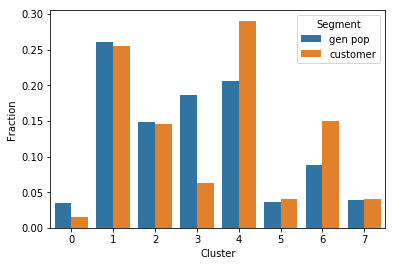

In [77]:
gen_pop_df = pd.DataFrame({'Cluster': gen_pop_x, 'Fraction': gen_pop_y, 'Segment': 'gen pop'})
customer_df = pd.DataFrame({'Cluster': cust_x, 'Fraction': cust_y, 'Segment': 'customer'})
comparison_df = pd.concat([gen_pop_df, customer_df], axis=0)
sns.barplot(x='Cluster', y='Fraction', hue='Segment', data=comparison_df)
plt.show()

In [78]:
print("Cluster   Center location by first three dimensions")
print("-------   -----------------------------------------")
for cluster in range(8):
    print("{:<10d}{}".format(cluster, model_8_clusters.cluster_centers_[cluster][:3]))

Cluster   Center location by first three dimensions
-------   -----------------------------------------
0         [ 0.29880837 -3.29988301 -2.90214599]
1         [ 2.77428225  3.70753491  0.18935435]
2         [-0.98541072 -3.76371841 -0.80582829]
3         [ 5.21751489 -2.67349025  0.09086829]
4         [-3.83013805  1.8572495   0.16490419]
5         [-4.47656189 -2.93336486  0.19145401]
6         [-5.16863172  0.95424212  0.72740367]
7         [-4.05469562 -3.96912776  1.24862421]


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

After performing a K-Means clustering algorithm with 8 clusters, one segment was clearly under-represented in the customer data, while two segments were over-represented. Cluster index 3 was under-represented in the customer data, and this cluster center was highly biased toward wealthy, older, conservative individuals. The two clusters that were over-represented in the data (indices 4 and 6) both were biased toward less wealthy individuals. Cluster index 4 was also strongly represented by younger, "liberal" individuals. In conclusion, the mail order company seems to have success with those that are looking for bargain purchases and may be still developing financially, *i.e.*, customers who are younger and still building financial wealth.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.